# **SENTIMENT ANALYSIS USING LSTM** **MODEL**



In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_datasets as tfds

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Visualizing Data
As we can see our data is distributed evenly 25k positive reviews and 25k negative reviews count plot is shown in the figure.

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Positive reviews are 249236 and negative reviews are 250000 of total 499236 


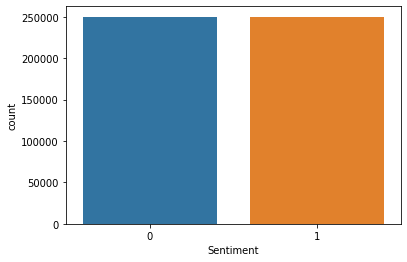

In [ ]:
dataset = pd.read_csv('/content/Hotel_data.csv')
negative = len(dataset[dataset['Sentiment']== 0])
positive = len(dataset) - negative
sns.countplot(dataset['Sentiment'])
print('Positive reviews are {} and negative reviews are {} of total {} '.format(positive,negative,len(dataset)))

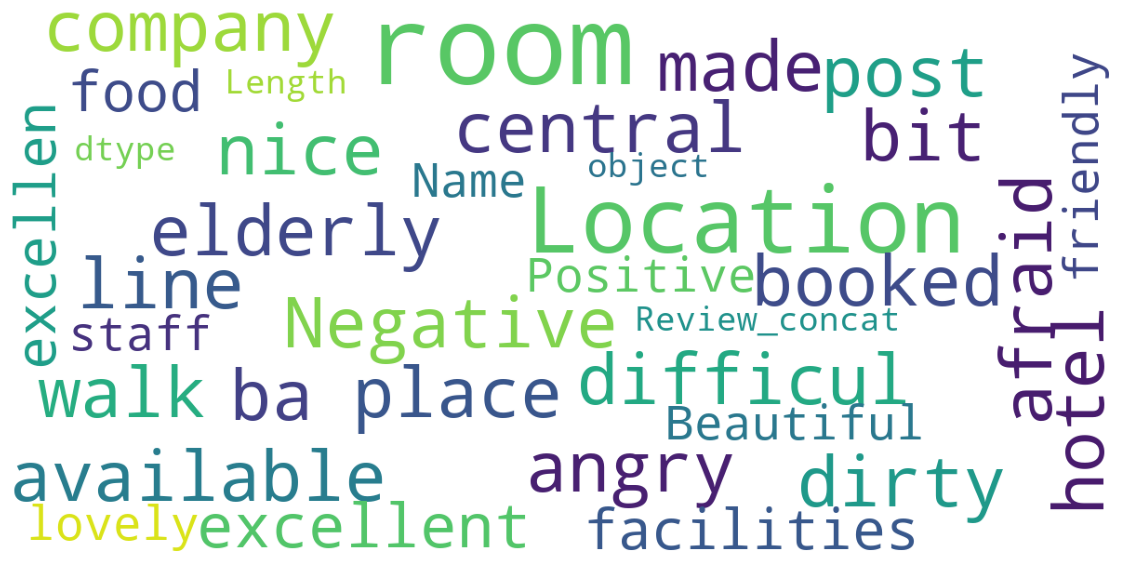

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 1000,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(dataset['Review_concat'])


# DATA PRE-PROCESSING

Converting the labels positve and negative as 1,0 so that they can be fed to the neural network to predict whether the given review is a positive or negative. Splitting of data 80% for the training and remaining 20% for testing.

In [ ]:
le = LabelEncoder()
training_reviews,testing_reviews,training_labels,testing_labels  = train_test_split(dataset['Review_concat'].values,dataset['Sentiment'].values,test_size = 0.2)
training_labels = le.fit_transform(training_labels)
testing_labels = le.fit_transform(testing_labels)

# Pre-Processing The Text
Using tokenizer to produce token for a given word and taking maximum length of 200 character of a review and after we simply truncate the input review and then padded the input to max len of 200.

In [ ]:
tokenizer = Tokenizer(num_words=10000,oov_token='<OOV>')
tokenizer.fit_on_texts(training_reviews)
word_index = tokenizer.word_index
training_sequence = tokenizer.texts_to_sequences(training_reviews)
testing_sequence = tokenizer.texts_to_sequences(testing_reviews)
train_pad_sequence = pad_sequences(training_sequence,maxlen = 200,truncating= 'post',padding = 'pre')
test_pad_sequence = pad_sequences(testing_sequence,maxlen = 200,truncating= 'post',padding = 'pre')
print('Total Unique Words : {}'.format(len(word_index)))

Total Unique Words : 46428


A word embedding is a class of approaches for representing words and documents using a dense vector representation.

It is an improvement over more the traditional bag-of-word model encoding schemes where large sparse vectors were used to represent each word or to score each word within a vector to represent an entire vocabulary. 

Two popular examples of methods of learning word embeddings from text include:

Word2Vec and GloVe.

//

Keras offers an Embedding layer that can be used for neural networks on text data.

It requires that the input data be integer encoded, so that each word is represented by a unique integer. This data preparation step can be performed using the Tokenizer API also provided with Keras.

The Embedding layer is defined as the first hidden layer of a network. It must specify 3 arguments:

It must specify 3 arguments:

**input_dim**: This is the size of the vocabulary in the text data. For example, if your data is integer encoded to values between 0-10, then the size of the vocabulary would be 11 words.

**output_dim**: This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. For example, it could be 32 or 100 or even larger. Test different values for your problem.

**input_length**: This is the length of input sequences, as you would define for any input layer of a Keras model. For example, if all of your input documents are comprised of 1000 words, this would be 1000.

# Using glove vectors for embedding

The Keras Embedding layer can also use a word embedding learned elsewhere.

It is common in the field of Natural Language Processing to learn, save, and make freely available word embeddings.

In our project we have used  “glove.6B.100d.txt“, which contains a 100-dimensional version of the embedding.

Keras provides a Tokenizer class that can be fit on the training data, can convert text to sequences consistently by calling the texts_to_sequences() method on the Tokenizer class, and provides access to the dictionary mapping of words to integers in a word_index attribute.

Next, we need to create a matrix of one embedding for each word in the training dataset. We can do that by enumerating all unique words in the Tokenizer.word_index and locating the embedding weight vector from the loaded GloVe embedding.

In [ ]:
#  entire GloVe word embedding file into memory as a dictionary of word to embedding array.
embedded_words = {}
with open('/content/glove.6B.100d.txt') as file:
    for line in file:
        words, coeff = line.split(maxsplit=1)
        coeff = np.array(coeff.split(),dtype = float)
        embedded_words[words] = coeff

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1,100))
for word, i in word_index.items():
    embedding_vector = embedded_words.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## **LSTM MODEL**


The layers are as follows:

1. An embedding layer that converts our word tokens (integers) into embeddings of a specific size.
2.An LSTM layer defined by a hidden_state size and number of layers
3.A fully-connected output layer that maps the LSTM layer outputs to a desired output_size
4.A sigmoid activation layer which turns all outputs into a value 0-1; return only the last sigmoid output as the output of this network.

# Creating The Model
layer1: Embedding Layer using glove weights

layer2: Using a Bidirectional LSTM

layer3: A dropout Layer

layer4: A Dense layer of 256 neurons with 'relu' activation

layer5: A Dense Layer of 128 neurons with 'relu' activation

layer6: Again a dropout layer.

layer7: Sigmoid activation layer to classify it positive and negative.

Since we chose 100-dimensional version of word embedding, the Embedding layer must be defined with output_dim set to 100. Finally, we do not want to update the learned word weights in this model, therefore we will set the trainable attribute for the model to be False.

In [ ]:
model = tf.keras.Sequential([tf.keras.layers.Embedding(len(word_index) + 1,100,weights=[embedding_matrix],input_length=200,
                            trainable=False),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(256,activation = 'relu',),
                             tf.keras.layers.Dense(128,activation = 'relu'),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(1,activation = tf.nn.sigmoid)])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          4642900   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

fit() is for training the model with the given inputs (and corresponding training labels).

In [27]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy() , optimizer='Adam' , metrics = 'accuracy')
history = model.fit(train_pad_sequence,training_labels,epochs = 20 ,validation_data=(test_pad_sequence,testing_labels))

Epoch 1/20
12481/12481 [==============================] - 239s 19ms/step - loss: 0.0980 - accuracy: 0.9679 - val_loss: 0.1362 - val_accuracy: 0.9581
Epoch 2/20
12481/12481 [==============================] - 236s 19ms/step - loss: 0.0971 - accuracy: 0.9682 - val_loss: 0.1489 - val_accuracy: 0.9589
Epoch 3/20
12481/12481 [==============================] - 236s 19ms/step - loss: 0.0977 - accuracy: 0.9680 - val_loss: 0.1364 - val_accuracy: 0.9597
Epoch 4/20
12481/12481 [==============================] - 236s 19ms/step - loss: 0.0977 - accuracy: 0.9680 - val_loss: 0.1348 - val_accuracy: 0.9594
Epoch 5/20
12481/12481 [==============================] - 235s 19ms/step - loss: 0.0966 - accuracy: 0.9682 - val_loss: 0.1467 - val_accuracy: 0.9587
Epoch 6/20
12481/12481 [==============================] - 235s 19ms/step - loss: 0.0957 - accuracy: 0.9684 - val_loss: 0.1495 - val_accuracy: 0.9590
Epoch 7/20
12481/12481 [==============================] - 236s 19ms/step - loss: 0.0981 - accuracy: 0.9681

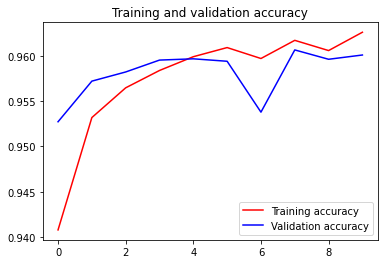

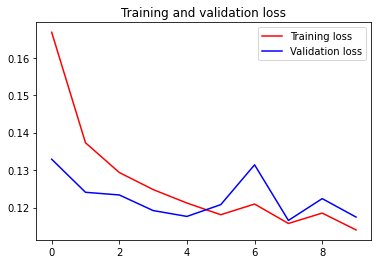

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()

In [ ]:
print('Training Accuracy: {}'.format(max(acc)))
print('Validation Accuracy: {}'.format(max(val_acc)))

Training Accuracy: 0.9626128077507019
Validation Accuracy: 0.9606602191925049


evaluate() is for evaluating the already trained model using the validation (or test) data and the corresponding labels. Returns the loss value and metrics values for the model.

In [ ]:
test_loss, test_acc = model.evaluate(test_pad_sequence,testing_labels, batch_size=200)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

500/500 [==============================] - 7s 13ms/step - loss: 0.1175 - accuracy: 0.9601
Test Loss: 0.11745670437812805
Test Accuracy: 0.9600993394851685


predict() is for the actual prediction. It generates output predictions for the input samples.

In [ ]:
twt = [' The floor in my room was filfy dirty Very basic rooms I had a 20yr old tv in my room Fridge did not work Overpriced breakfast ']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=28, dtype='int32', value=0)
print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
print(sentiment)
if(round(sentiment[0]) == 0):
    print("negative")
elif (round(sentiment[0]) == 1):
    print("positive")

[[  0   0   2 110   8  45   7   4   1 344   9 505  40  15  31   6   1 170
  192   8  45   7 384 101  21 144 704  22]]
1/1 - 0s
[0.01592517]
negative


In [ ]:
twt = [' Bed was extremely comfy and the staff where well spoken they also gave us all the help with easiest way to city centre and all the relevant transportation tickets and unique locations to visit will definitely be returning as this city is beautiful and the people are so friendly ']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=28, dtype='int32', value=0)
print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
print(sentiment)
if(round(sentiment[0]) == 0):
    print("negative")
elif (round(sentiment[0]) == 1):
    print("positive")

[[ 281  511    3   50    2 5311 1246 1614    3 1473 1497    5  379  127
   187   52 1010   39   44  281   19  169    3    2  173   54   43   32]]
1/1 - 0s
[0.9924601]
positive


In [ ]:
# predict probabilities for test set
yhat_probs = model.predict(test_pad_sequence, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(test_pad_sequence, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]



Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testing_labels, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testing_labels, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testing_labels, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testing_labels, yhat_classes)
print('F1 score: %f' % f1)
# confusion matrix
matrix = confusion_matrix(testing_labels, yhat_classes)
print(matrix)

Accuracy: 0.960099
Precision: 0.964336
Recall: 0.955397
F1 score: 0.959846
[[48247  1761]
 [ 2223 47617]]


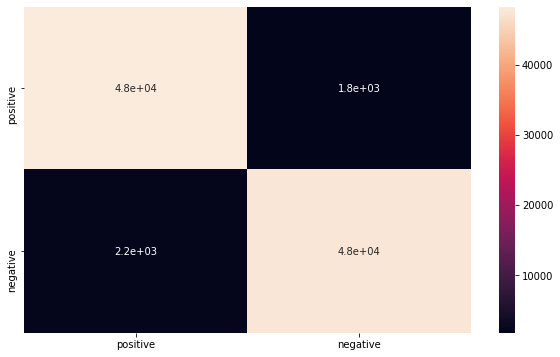

In [ ]:
import seaborn as sns
cm =confusion_matrix(testing_labels, yhat_classes)  
index = ['positive','negative']  
columns = ['positive','negative']  
cm_df = pd.DataFrame(cm,columns,index)                      
plt.figure(figsize=(10,6))  
sns.heatmap(cm_df, annot=True)

In [ ]:
#Classification report for performance metrics
cr_rnn=classification_report(testing_labels, yhat_classes)
print('The Classification report is::\n',cr_rnn)

The Classification report is::
               precision    recall  f1-score   support

           0       0.96      0.96      0.96     50008
           1       0.96      0.96      0.96     49840

    accuracy                           0.96     99848
   macro avg       0.96      0.96      0.96     99848
weighted avg       0.96      0.96      0.96     99848

